In [1]:
from google.colab import drive
drive.mount('/gdrive/')
%cd /gdrive

Mounted at /gdrive/
/gdrive


In [2]:
ls

MyDrive/  Shareddrives/


In [3]:
cd/gdrive/MyDrive/Coal type classification/

/gdrive/MyDrive/Coal type classification


In [4]:
ls

Anthracite/  Lignite/  Peat/


In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing.image import load_img

In [6]:
import os
import PIL
import pathlib
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.ops.numpy_ops import np_utils

In [31]:
BATCH_SIZE = 62
IMAGE_SIZE = 256
EPOCHS=30
CHANNELS=3

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/gdrive/MyDrive/Coal type classification",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 260 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Anthracite', 'Lignite', 'Peat']

In [10]:
len(dataset)

5

In [11]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(image_batch[1])
  print(label_batch.numpy())

(62, 256, 256, 3)
tf.Tensor(
[[[ 72.       74.       71.     ]
  [ 73.       75.       72.     ]
  [ 73.       75.       72.     ]
  ...
  [ 71.       71.       71.     ]
  [ 71.       71.       71.     ]
  [ 71.94531  71.94531  71.94531]]

 [[ 72.       74.       71.     ]
  [ 73.       75.       72.     ]
  [ 73.       75.       72.     ]
  ...
  [ 71.       71.       71.     ]
  [ 71.       71.       71.     ]
  [ 71.5625   71.5625   71.5625 ]]

 [[ 72.       74.       71.     ]
  [ 73.       75.       72.     ]
  [ 73.       75.       72.     ]
  ...
  [ 71.       71.       71.     ]
  [ 71.       71.       71.     ]
  [ 71.21094  71.21094  71.21094]]

 ...

 [[129.      129.      127.     ]
  [128.6875  128.6875  126.6875 ]
  [127.30469 127.30469 125.30469]
  ...
  [126.375   126.375   124.375  ]
  [123.19531 123.19531 121.19531]
  [121.58594 121.58594 119.58594]]

 [[129.      129.      127.     ]
  [128.6875  128.6875  126.6875 ]
  [127.92969 127.92969 125.92969]
  ...
  [127.50

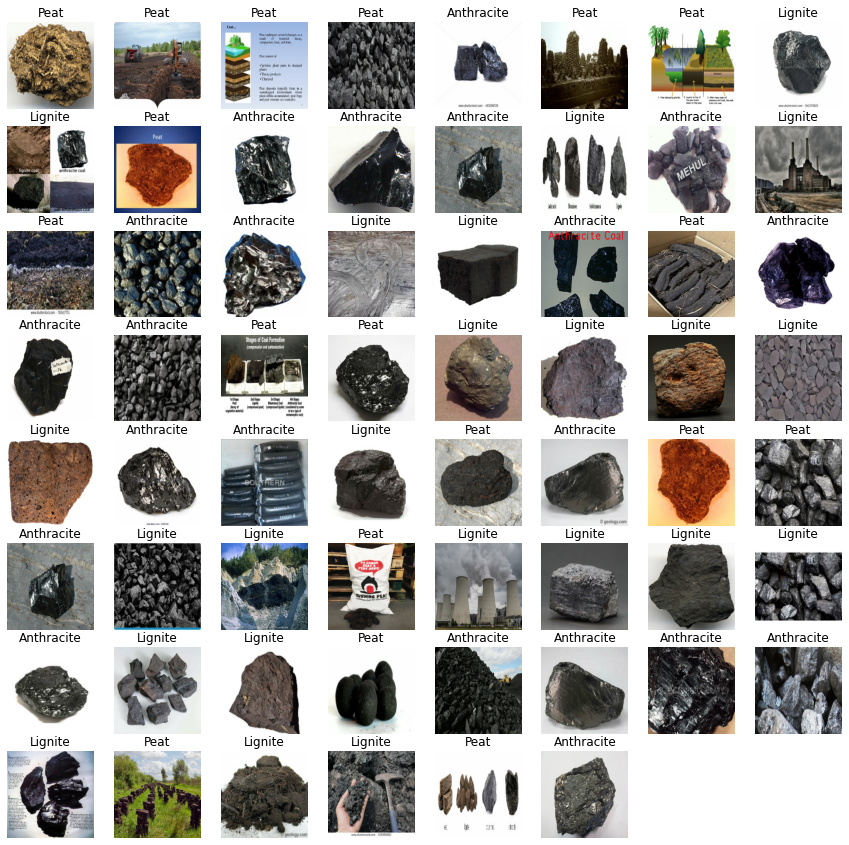

In [12]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(8, 8, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    # Autotune all the 3 datasets 
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 9

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [29]:
model.compile(
    optimizer='nadam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (62, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (62, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (62, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (62, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (62, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (62, 60, 60, 64)         

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
4/4 [==============================] - 20s 6s/step - loss: 0.7485 - accuracy: 0.6970
Epoch 2/30
4/4 [==============================] - 20s 6s/step - loss: 0.5191 - accuracy: 0.8283
Epoch 3/30
4/4 [==============================] - 19s 4s/step - loss: 0.6192 - accuracy: 0.7525
Epoch 4/30
4/4 [==============================] - 20s 4s/step - loss: 0.4092 - accuracy: 0.8636
Epoch 5/30
4/4 [==============================] - 20s 4s/step - loss: 0.3468 - accuracy: 0.8939
Epoch 6/30
4/4 [==============================] - 20s 4s/step - loss: 0.6617 - accuracy: 0.7172
Epoch 7/30
4/4 [==============================] - 20s 4s/step - loss: 0.3844 - accuracy: 0.8737
Epoch 8/30
4/4 [==============================] - 20s 4s/step - loss: 0.2797 - accuracy: 0.9141
Epoch 9/30
4/4 [==============================] - 20s 4s/step - loss: 0.3283 - accuracy: 0.8788
Epoch 10/30
4/4 [==============================] - 20s 4s/step - loss: 0.3171 - accuracy: 0.9040
Epoch 11/30
4/4 [======================

In [33]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.4179 - accuracy: 0.8387


[0.41792774200439453, 0.8387096524238586]

In [34]:
acc = history.history['accuracy']
loss = history.history['loss']

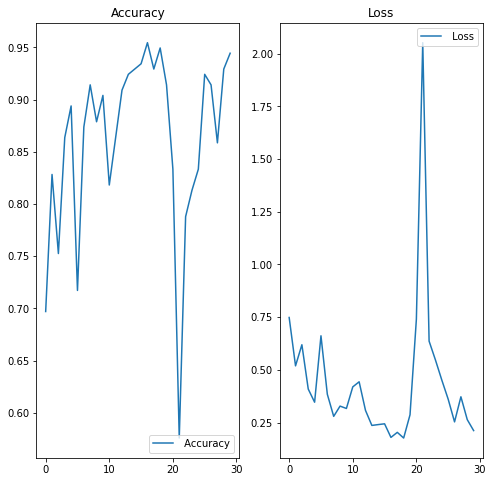

In [35]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label=' Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label=' Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

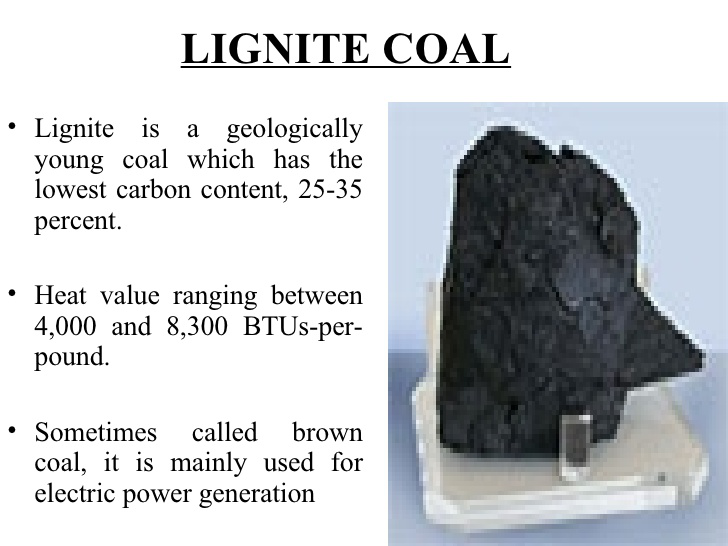

In [36]:
image_path = "/gdrive/My Drive/93.jpg"
image = preprocessing.image.load_img(image_path)
image_array = preprocessing.image.img_to_array(image)
scaled_img = np.expand_dims(image_array, axis=0)
image

In [37]:
pred = model.predict(scaled_img)

In [38]:
output = class_names[np.argmax(pred)]

In [39]:
output

'Lignite'

In [40]:
model.save("Coal type classification.h5")